## Extract and Prepare training data

In [1]:
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Import training data

In [2]:
non_vehicle_images = glob.glob('non_vehicles/*/*.png')
vehicle_images = glob.glob('vehicles/*/*.png')

cars = []
notcars = []

for image in non_vehicle_images:
    notcars.append(image)
    
for image in vehicle_images:
    cars.append(image)

#### Explore imported data

There are 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Text(0.5,1,'Example Not-car Image')

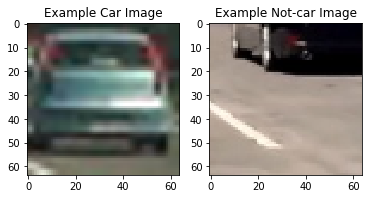

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('There are', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Extract image features

### Color features

In [4]:
# Converts image color cspace.
def convert_color(image, cspace='BGR'):
    # apply color conversion if other than 'BGR'
    if cspace != 'BGR':
        if cspace == 'HSV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: converted_image = np.copy(image)
    return converted_image

# Computes binned color features  
def bin_spatial(img, spatial_size=(8, 8)):
    # Create the feature vector
    return cv2.resize(img, spatial_size).ravel() 

# Computes color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### Explore training with color features

In [5]:
# Extracts and combines color and color histogram features of an image.
def extract_color_features(imgs, cspace='YUV'):
    features = []
    for file in imgs:
        image = cv2.imread(file)
        feature_image = convert_color(image, cspace)
        spatial_features = bin_spatial(feature_image)
        hist_features = color_hist(feature_image)
        features.append(np.concatenate((spatial_features, hist_features)))
    return features

spatial = 8
histbin = 32

car_features = extract_color_features(cars, cspace='YUV')
notcar_features = extract_color_features(notcars, cspace='YUV')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Label the features
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC') 

Using spatial binning of: 8 and 32 histogram bins
Feature vector length: 288
4.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9747
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
0.00311 Seconds to predict 10 labels with SVC


### HOG features

In [6]:
# Extracts HOG features and optionally visualizes output.
def get_hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    '''Returns two outputs if vis==True otherwise returns a single output'''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### Explore HOG features

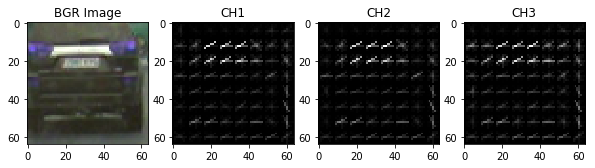

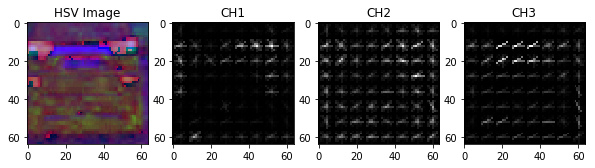

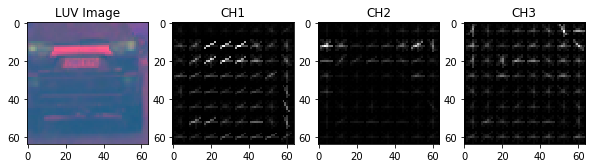

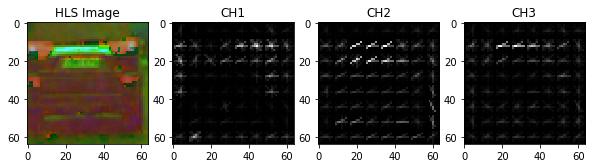

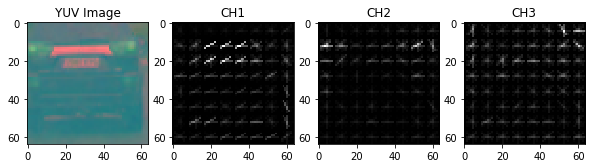

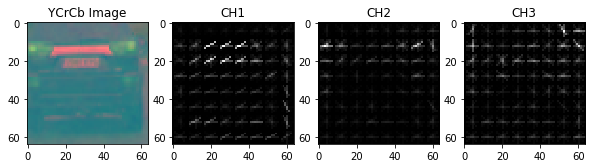

In [7]:
def extract_hog_features(img, cspace='YUV'):
    '''
    Return converted image and list of HOG images for each channel if in explore mode,
    otherwise, return HOG feature vectors.
    '''
    image = cv2.imread(img)
    feature_image = convert_color(image, cspace)      

    hog_images = []
    for channel in range(feature_image.shape[2]):
        features, hog_image = get_hog_features(feature_image[:,:,channel], vis=True, feature_vec=False)
        hog_images.append(hog_image)
    return feature_image, hog_images

color_spaces = ['BGR', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

car_ind = np.random.randint(0, len(cars))

for row, color_space in enumerate(color_spaces):
    color_image, hog_images = extract_hog_features(cars[car_ind], cspace=color_space)
    fig = plt.figure(figsize=(10,4))
    plt.subplot(1,4,1)
    plt.imshow(color_image)
    plt.title(color_space + ' Image')
    plt.subplot(1,4,2)
    plt.imshow(hog_images[0], cmap='gray')
    plt.title('CH1')
    plt.subplot(1,4,3)
    plt.imshow(hog_images[1], cmap='gray')
    plt.title('CH2')
    plt.subplot(1,4,4)
    plt.imshow(hog_images[2], cmap='gray')
    plt.title('CH3')

##### Exploration shows:
- For Color Channels: Using all YUV channels works best across all situations
    - RGB is best on very clear images with bright(white) cars where all channel values are high
    - LUV, YUV and YCrCb higlight very similar features
    - HLS and HSV are prone to be noisy
    - The L and U channels of HLS, LUV, YUV and YCrCb adjust well to color changes
    - The V and BC channels of LUV, YUV and YCrBc higlight the tail and head lights most effectively
    - Combining all channels of LUV will work best
- For HOG params:
    - 8 Orientations worked best (north, north-east, east, south-east, south, south-west, west, north-west)
    - Less pixels per cell give higher definition but is slower. 8 pixels per cell worked best.

### Combine extracted features

In [8]:
# Extracts HOG and Color features from the provided image.
def extract_features(image, cspace='YUV'):
    feature_image = convert_color(image, cspace)
    spatial_features = bin_spatial(feature_image)
    hist_features = color_hist(feature_image)
    hog_features_list = []
    for channel in range(feature_image.shape[2]):
        hog_features = get_hog_features(feature_image[:,:,channel], vis=False, feature_vec=True)
        hog_features_list.append(hog_features)
    color_features = np.concatenate((spatial_features, hist_features))
    return np.concatenate((color_features, np.concatenate(hog_features_list)))

### Train classifier with image features

In [9]:
def image_features(image_paths, cspace):
    features = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        features.append(extract_features(image, cspace=cspace))
    return features
    
def train_classifier(cars, notcars, cspace='YUV'):

    t=time.time()
    car_features = image_features(cars, cspace)
    notcar_features = image_features(notcars, cspace)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG and Color features...')
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    # Label the feature vectors
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Feature vector length:', len(X_train[0]))
    svc = LinearSVC()
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler

#### Explore training with HOG and Color Features

In [10]:
sample_size = 500

train_classifier(cars[0:sample_size], notcars[0:sample_size], cspace='YUV')

9.56 Seconds to extract HOG and Color features...
Feature vector length: 4992
0.22 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
0.00295 Seconds to predict 10 labels with SVC


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

### Draw bounding boxes

In [11]:
# Draws bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

#### Explore bounding boxes

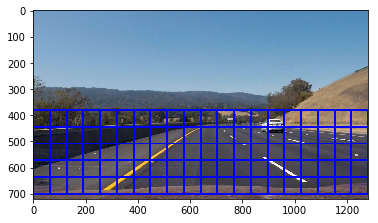

In [12]:
# Function that fits multiple windows of the specified size across the provided image.
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    img_size = img.shape
    if x_start_stop[0] == None:
        x_start_stop = (0, x_start_stop[1])
    if x_start_stop[1] == None:
        x_start_stop = (x_start_stop[0], img_size[1])
    if y_start_stop[0] == None:
        y_start_stop = (0, y_start_stop[1])
    if y_start_stop[1] == None:
        y_start_stop = (y_start_stop[0], img_size[0])
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

image = mpimg.imread('test_images/test3.jpg')
windows = slide_window(image, y_start_stop=(380, None), xy_window=(128, 128))
window_img = draw_boxes(image, windows)                    
plt.imshow(window_img)

### Search for windows with vehicles

In [13]:
def find_cars(img, ystart, ystop, classifier, scaler, cspace='YUV', scale=1.5, pix_per_cell=8, cell_per_block=2):
    '''
    Searches the image through windows of increasing scale for the presence of a vehicle.
    Ensure image is in BGR color space
    '''
    draw_image = np.copy(img)
    img_to_search = img[ystart:ystop,:,:]
    img_to_search = convert_color(img_to_search, cspace)
    
    if scale != 1:
        imshape = img_to_search.shape
        img_to_search = cv2.resize(img_to_search, (int(imshape[1] / scale), int(imshape[0] / scale)))
        
    ch1 = img_to_search[:,:,0]
    ch2 = img_to_search[:,:,1]
    ch3 = img_to_search[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 is the sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute HOG features for the entire image once.
    hog1 = get_hog_features(ch1, feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    vehicle_windows = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.concatenate((hog_feat1, hog_feat2, hog_feat3))
           
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            sub_img = cv2.resize(img_to_search[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(sub_img)
            hist_features = color_hist(sub_img)
            color_features = np.concatenate((spatial_features, hist_features))
            all_features = np.vstack([np.concatenate((color_features, hog_features))]).astype(np.float64)

            scaled_features = X_scaler.transform(all_features)
            prediction = svc.predict(scaled_features)
            
            if prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                vehicle_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    return vehicle_windows, draw_boxes(draw_image, vehicle_windows, (255,0,0))

#### Explore vehicle search

##### Train

In [14]:
ystart = 400
ystop = 656
scale = 1.5
c_index = 4
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
svc, X_scaler = train_classifier(cars[0:1000], notcars[0:1000], cspace=color_spaces[c_index])

24.41 Seconds to extract HOG and Color features...
Feature vector length: 4992
0.61 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
0.00355 Seconds to predict 10 labels with SVC


##### Predict

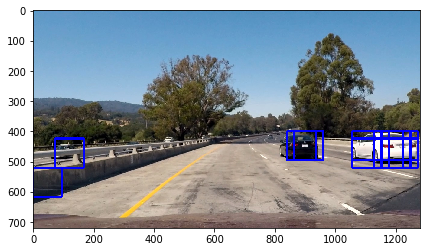

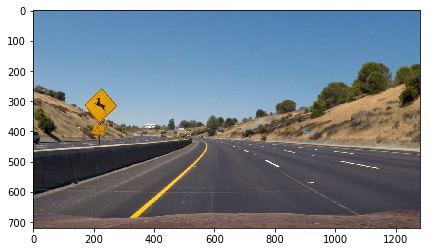

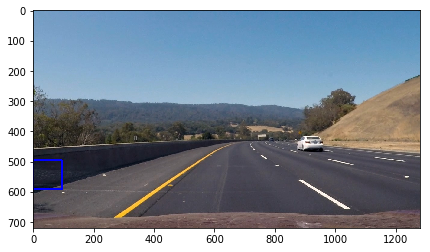

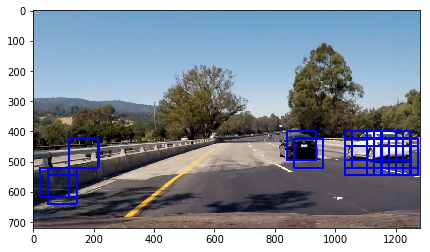

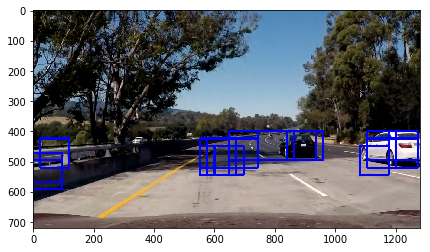

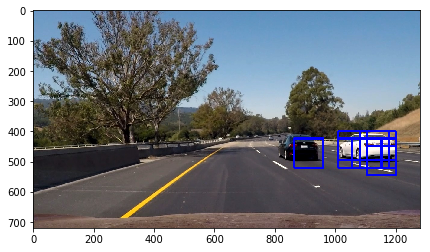

In [15]:
for image_path in glob.glob('test_images/*.jpg'):
    image = cv2.imread(image_path)
    vehicle_windows, out_img = find_cars(image, ystart, ystop, svc, X_scaler, cspace=color_spaces[c_index], scale=scale)
    fig = plt.figure(figsize=(10,4))
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

### Detect vehicles at multiple scales

In [16]:
def find_all_cars(image, ystart, ystop, classifier, scaler, cspace, scales=[1.0]):
    all_vehicle_windows = []
    for scale in scales:
        vehicle_windows, out_img = find_cars(image, ystart, ystop, classifier, scaler, cspace, scale=scale)
        all_vehicle_windows.extend(vehicle_windows)
    return all_vehicle_windows


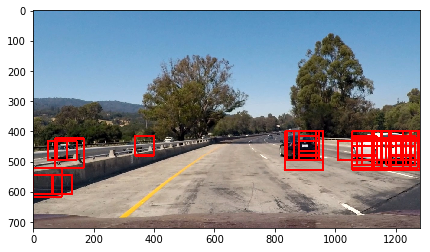

In [17]:
image = cv2.imread('test_images/test1.jpg')
car_boxes = find_all_cars(image, ystart, ystop, svc, X_scaler, cspace=color_spaces[c_index], scales=[1.0, 1.5, 2.0])
fig = plt.figure(figsize=(10,4))
out_img = draw_boxes(image, car_boxes)
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

### Create heat map of detected vehicles and eliminate outliers

In [18]:
def add_heat(heatmap, bboxes):
    for bbox in bboxes:
        # Add += 1 for all pixels inside each bbox
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(image, labels):
    # Draw box for each detected car
    detected_cars = []
    for car in range(1, labels[1]+1):
        # Find pixels with each car label value
        nonzero = (labels[0] == car).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        detected_cars.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    return draw_boxes(image, detected_cars)

def drop_outliers(image, detected_bboxes, threshold=4):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,detected_bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap  
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap

#### Explore heat map

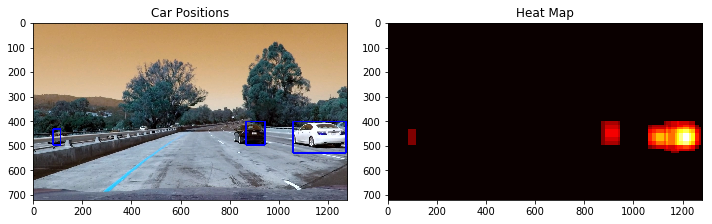

In [19]:
draw_img, heatmap = drop_outliers(image, car_boxes, threshold=2)
fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
    
    

### Car detection Pipeline

In [20]:
# Train Classifier

c_index = 4
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
svc, X_scaler = train_classifier(cars, notcars, cspace=color_spaces[c_index])

180.53 Seconds to extract HOG and Color features...
Feature vector length: 4992
29.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  1.]
0.01914 Seconds to predict 10 labels with SVC


In [21]:
ystart = 400
ystop = 656
scales = [1.0, 1.5, 2.0]

def detect_cars(image, ystart, ystop, svc, X_scaler, cspace, scales):
    vehicle_windows = find_all_cars(image, ystart, ystop, svc, X_scaler, cspace=cspace, scales=scales)
    draw_img, heatmap = drop_outliers(image, vehicle_windows)
    return draw_img


In [22]:
project_video_output = 'output_videos/project.mp4'
clip = VideoFileClip("project_video.mp4")
frames = []
for frame in clip.iter_frames():
    frames.append(detect_cars(frame, ystart, ystop, svc, X_scaler, color_spaces[c_index], scales))
image_sequence = ImageSequenceClip(frames, fps=clip.fps)
%time image_sequence.write_videofile(project_video_output, fps=clip.fps)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

[MoviePy] >>>> Building video output_videos/project.mp4
[MoviePy] Writing video output_videos/project.mp4


100%|██████████| 1260/1260 [01:31<00:00, 13.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project.mp4 

CPU times: user 3.46 s, sys: 13.6 s, total: 17 s
Wall time: 1min 34s
